## Estimating Violent Crime Using Murder Rate in the United States
#### Daniel Verdear for Safe-esteem

A primary goal of scaling the Safe-esteem model is identifying a data proxy for violent crime. In some jurisdictions, violent crime reporting is very dubious, but homicides are much more likely to be reported given their concrete evidence and high impact. It would be incredibly useful to risk scoring if total violent crime could be estimated using a heuristic algorithm based on population and homicides. 

This experiment will test the viability of this idea by using a machine learning approach to analyze data from approximately 250 municipalities in the United States. The data was lifted from the UCR repository and, due to the structure of the Excel table, reorganized and simplified to best fit the methodology of this experiment. Of all reporting municipalities, the 250 were chosen at random (so they are NOT necessarily a representative sample) using numpy's random number generator.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [2]:
df = pd.read_csv('simplified table6.csv')
#df.astype('float64')
print(df.shape)
df.head()

(251, 3)


,population,vc,homicide
0,122981,636,4
1,197412,1377,42
2,73209,827,22
3,53701,56,0
4,98174,876,8


In machine learning, the contents of non-target variables (in this case, all columns other than violent crime vc) are extremely important to monitor. Other columns in the original dataset include the number of rapes, assaults, etc. These, however, are a subset of the violent crime total. 

If we leave those in the dataset, our regression model will only tell us "Add up murders, rapes, assaults, and robberies to get the total violent crime". While that's right, it's a fact that is of no use to us. So, the dataset has been simplified down to just population and homicide, trying to predict vc.

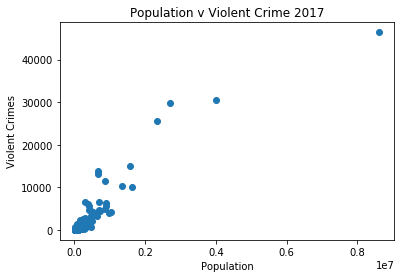

In [3]:
plt.scatter(df['population'],df['vc'])
plt.title('Population v Violent Crime 2017')
plt.xlabel('Population')
plt.ylabel('Violent Crimes')
plt.show()

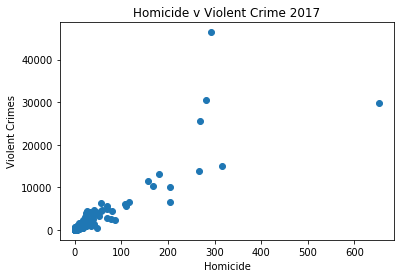

In [4]:
plt.scatter(df['homicide'],df['vc'])
plt.title('Homicide v Violent Crime 2017')
plt.xlabel('Homicide')
plt.ylabel('Violent Crimes')
plt.show()

If the illegible axes don't give it away immediately, these scatter plots are too compressed to glean much from visually. The population vs violent crime plot struggles to fit one outlier case where the population exceeds 8 million. This compresses the majority of the data into a region too small to analyze visually. The homicide vs violent crime plot seems to be skewed by small municipalities with 0 homicides. Additionally, it is also victim to the skewing caused by a few major cities that were included.

For our machine learning application, the two attributes of population and homicide rate will be combined to predict violent crime, so the plots would be in three dimensions. Due to the complexity of these plots, we will only pursue plotting in three dimensions if the regression model returns promising results.

In [5]:
x = df[['population','homicide']]
y = df['vc']

x_tr, x_te, y_tr, y_te = train_test_split(x,y,test_size=0.2)

In [6]:
reg = LinearRegression()
reg.fit(x_tr,y_tr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [7]:
coef_df = pd.DataFrame(reg.coef_,x.columns, columns=['Coefficient'])
coef_df

,Coefficient
population,0.004724
homicide,30.482362


The regression model has fit an equation that, given the population and number of homicides, SHOULD return the number of violent crimes.

# (population/225) + 33*homicides = Violent crimes

This is the general form of the equation. Given the slight randomness introduced by the training and testing set split, this may fluctuate by small factors. But, this remains the basis of the equation.

Sklearn will fit any data to any result in THE MOST OPTIMAL way. It's definition of most optimal may not be in line with the accuracy required by Safe-esteem. To check our work, 20% of our dataset was kept aside to test. The regression model will compute violent crime totals for these municipalities and compare them to the actual value.

In [8]:
y_pred = reg.predict(x_te)

result = pd.DataFrame({'Actual': y_te, 'Predicted': y_pred})
result

,Actual,Predicted
149,112,116.128111
175,103,72.658916
45,37,-113.073118
48,15,-152.080861
224,114,233.030315
228,1737,1109.937112
219,194,75.885546
120,260,86.597119
179,323,98.048587
160,324,268.468366


In [9]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_te, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_te, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_te, y_pred)))

Mean Absolute Error: 339.37021430377416
Mean Squared Error: 477908.0248304377
Root Mean Squared Error: 691.3089214167843


The results are extremely poor for this experiment.

The Root Mean Square Error can be interpreted as saying the model will incorrectly predict the total violent crime in a municipality by nearly 700. This is clearly unacceptable, especially since some municipalioties have been predicted to have negative(!) violent crime totals. This is likely a demographic issue. The United States is an incredibly diverse country, with more duality between urban and rural than should be expected in smaller countries. 

Perhaps this analysis can be more useful if we assume that countries that lack the infrastructure to maintain records of violent crime may have more uniform urban/rural distribution. Perhaps adding more variables to this analysis will create a better result. Then the issue becomes what variables and how to access them. 

Ultimately, this coincides with the conclusion of the first analysis. On a nationwide aggregate, murder and violent crime seem to correlate nearly linearly. As the scale gets smaller, the trend breaks. At the municipality level, the trend is nearly nonexistant, so some examples have a predicted violent crime total off by a factor of 4.